# Logistic and other regressions

In [48]:
import time
import os

import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

import matplotlib.pyplot as plt
import arviz as az

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)


## Logistics regression: one dimensional version

Let us simulate appropriate data and define a logistic regression model using Numpyro. We will need to chose priors for the intercept (alpha) and for the coefficients (beta). We then will use the NUTS sampler to obtain posterior samples for alpha and beta from the Bayesian model. Finally, we will print the posterior means of alpha and beta.

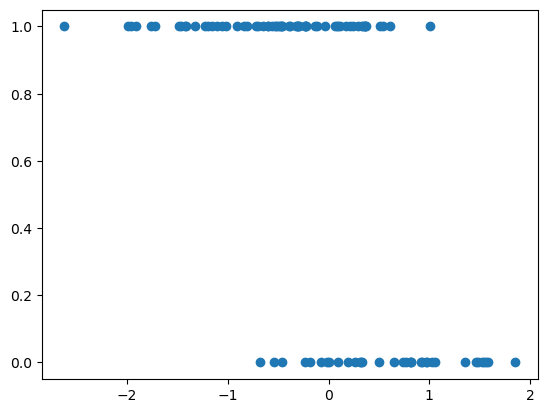

In [49]:
# Generate  synthetic data
np.random.seed(42)
X = np.random.randn(100, 1)
true_beta = jnp.array([ -2.0])
true_alpha = 0.5
logits = jnp.dot(X, true_beta) + true_alpha
probs = 1.0 / (1.0 + jnp.exp(-logits))
y = np.random.binomial(1, probs)

plt.scatter(X, y)

In [50]:
# Define the logistic regression model
def logistic_regression_model(X, y=None):

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    # precompute logits, i.e. the linear predictor
    logits = alpha + jnp.dot(X, beta)

    # likelihood. Remember how to use plates?
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [51]:
# Define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# Run NUTS sampler
nuts_kernel = NUTS(logistic_regression_model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup)

rng_key = random.PRNGKey(67)
mcmc.run(rng_key, X=X, y=y)



sample: 100%|██████████| 1500/1500 [00:02<00:00, 667.85it/s, 3 steps of size 7.19e-01. acc. prob=0.93] 


Posterior mean of alpha: 0.73553663

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.74      0.26      0.73      0.38      1.20    832.20      1.00
   beta[0]     -2.10      0.39     -2.08     -2.74     -1.45    542.46      1.00

Number of divergences: 0


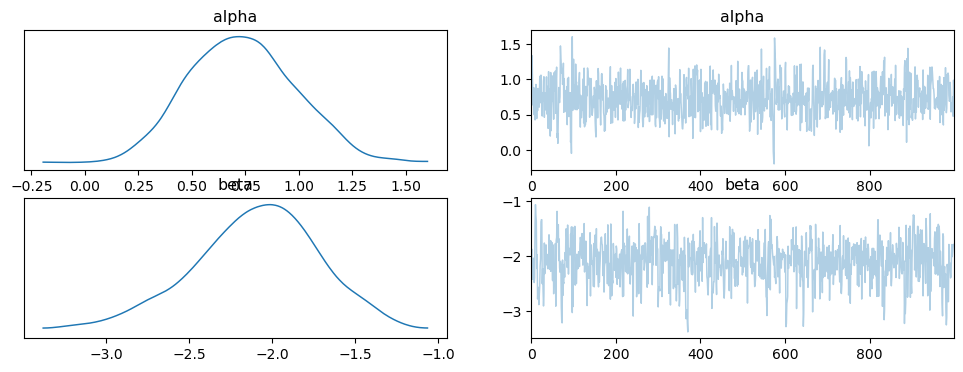

In [52]:
# Get posterior samples
samples = mcmc.get_samples()

# Print posterior statistics
print("Posterior mean of alpha:", jnp.mean(samples['alpha']))
#print("Posterior mean of beta:", jnp.mean(samples['beta'], axis=0))

# mean is not enough
mcmc.print_summary()

# plot posterior distribution and traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);


## Writing a general function for MCMC inference flow

Note that the Numpyro model which we wrote is generic with respect to dimentionality of `X` (well done us!).

However, we have already repeated the same code several times. Let us wrap the inference flow into a funation, and then apply to the case with two features and weights.

In [53]:
def run_mcmc(rng_key,       # random key
             model,         # Numpyro model
             args,          # Dictionary of arguments
             verbose=True   # boolean for verbose MCMC
            ):
    
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_mcmc_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    start = time.time()
    mcmc.run(rng_key, args)
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    
    # print summary
    mcmc.print_summary()

    # plot posterior distribution and traceplots
    data = az.from_numpyro(mcmc);
    az.plot_trace(data, compact=True);

    return mcmc, mcmc.get_samples(), t_elapsed

As an input, rather than specofocally providing `X` and `y`, we will provide a dictionary `args` with data, as well as other parameters for MCMC.

## Logistics regression: two-dimensional version



In [55]:
# Define the logistic regression model
def logistic_regression_model(args): # notice the `args`!

    X = args["X"]
    y = args["y"]

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    # precompute logits, i.e. the linear predictor
    logits = alpha + jnp.dot(X, beta)

    # likelihood. Remember how to use plates?
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [56]:
# Generate synthetic data
np.random.seed(42)
X = np.random.randn(100, 2)
true_beta = jnp.array([1.0, -2.0])
true_alpha = 0.5
logits = jnp.dot(X, true_beta) + true_alpha
probs = 1.0 / (1.0 + jnp.exp(-logits))
y = np.random.binomial(1, probs)


/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_92079/4288946791.py:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 688.07it/s, 7 steps of size 8.88e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.65      0.28      0.64      0.16      1.07   3022.84      1.00
   beta[0]      0.86      0.31      0.86      0.37      1.36   3147.69      1.00
   beta[1]     -2.06      0.39     -2.03     -2.67     -1.41   3051.65      1.00

Number of divergences: 0

MCMC elapsed time: 9 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.65      0.28      0.64      0.16      1.07   3022.84      1.00
   beta[0]      0.86      0.31      0.86      0.37      1.36   3147.69      1.00
   beta[1]     -2.06      0.39     -2.03     -2.67     -1.41   3051.65      1.00

Number of divergences: 0


(<numpyro.infer.mcmc.MCMC at 0x12be13d60>,
 {'alpha': Array([0.21656764, 0.3994844 , 1.1256942 , ..., 0.86023647, 0.7621606 ,
         0.7493835 ], dtype=float32),
  'beta': Array([[ 1.2764634 , -1.7683538 ],
         [ 0.8126135 , -1.7481163 ],
         [ 1.1616341 , -2.8151855 ],
         ...,
         [ 0.59143186, -1.9530377 ],
         [ 0.6144451 , -1.9385039 ],
         [ 1.0264962 , -2.300866  ]], dtype=float32)},
 9.2672438621521)

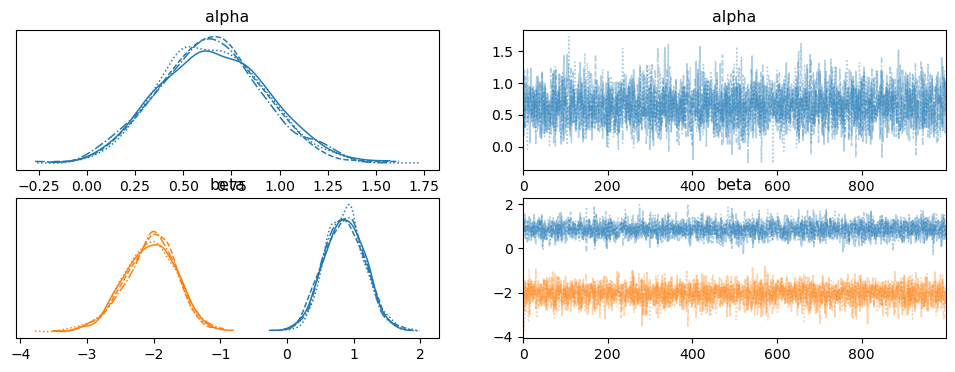

In [57]:
args = {'X': X, 
        'y':y,
        'num_mcmc_samples': 1000,
        'num_warmup': 500,
        'num_chains': 4, 
        'thinning': 1,
}

run_mcmc(rng_key, logistic_regression_model, args)

## Poisson regression

In [58]:
# Generate synthetic data
np.random.seed(42)
X = np.random.randn(1000, 2)
true_beta = jnp.array([0.5, -1.5])
true_alpha = 1.0

true_lambda = jnp.exp(true_alpha + jnp.dot(X, true_beta))
y = np.random.poisson(true_lambda)


In [59]:
# Define the Poisson regression model
def poisson_regression_model(args):

    X = args["X"]
    y = args["y"]

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    
    # Poisson regression
    lambda_ = jnp.exp(alpha + jnp.dot(X, beta))
    
    # likelihood
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(lambda_), obs=y)

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_92079/4288946791.py:9: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 602.74it/s, 15 steps of size 3.57e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.98      0.02      0.98      0.95      1.02    715.76      1.00
   beta[0]      0.49      0.01      0.49      0.47      0.51   1134.37      1.00
   beta[1]     -1.52      0.01     -1.52     -1.54     -1.50    710.98      1.00

Number of divergences: 0

MCMC elapsed time: 5 s

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.98      0.02      0.98      0.95      1.02    715.76      1.00
   beta[0]      0.49      0.01      0.49      0.47      0.51   1134.37      1.00
   beta[1]     -1.52      0.01     -1.52     -1.54     -1.50    710.98      1.00

Number of divergences: 0


(<numpyro.infer.mcmc.MCMC at 0x12c2d8ee0>,
 {'alpha': Array([0.98814416, 0.96745694, 0.9721584 , ..., 0.9676529 , 0.9833631 ,
         0.97209245], dtype=float32),
  'beta': Array([[ 0.4986962 , -1.5032464 ],
         [ 0.5016759 , -1.5363169 ],
         [ 0.5003391 , -1.5242897 ],
         ...,
         [ 0.4900542 , -1.5274057 ],
         [ 0.48092988, -1.5196061 ],
         [ 0.47770953, -1.5192877 ]], dtype=float32)},
 4.964793920516968)

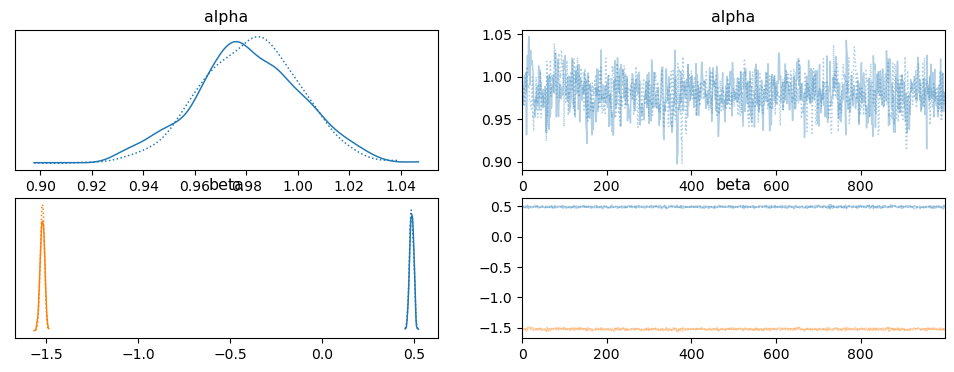

In [60]:
args = {'X': X, 
        'y':y,
        'num_mcmc_samples': 1000,
        'num_warmup': 500,
        'num_chains': 2, 
        'thinning': 1,
}

run_mcmc(rng_key, poisson_regression_model, args)